## Import data from drive

In [0]:
from google.colab import drive, files
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn

In [0]:
url = "https://drive.google.com/uc?export=download&id=1qzRgnhQ5v9yKxEEjXN_M2yvmlimu1a-S" 
df = pd.read_excel(url, header=0, index_col=0)
df = df.reset_index()

## Data Preprocessing



### 1.Set Random set to "123"

In [0]:
import numpy as np
seed = 123
np.random.seed(seed)

### 2. Shuffle the data randomly (the rows)

In [0]:
df_array = df.values
np.random.shuffle(df_array)
df = pd.DataFrame(data = df_array,
                  columns = df.columns)

### 3.Perform min/max normalization on the numeric DW columns, the ALAND and AWATER columns.

In [0]:
from sklearn.preprocessing import MinMaxScaler
from numpy import set_printoptions

#Select "aland", "awater" , and other DW columns.
x = pd.concat([df.filter(items=['ALAND', 'AWATER']),df.filter(like='DW', axis=1)],axis =1)
labels = x.columns

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(x)
dw_scaled = scaler.fit_transform(x)

#Set precision for datafram. The below is the code for numpy 
#set_printoptions(precision=4)
pd.set_option("display.precision", 4)

df_scaled = pd.DataFrame(dw_scaled, columns=labels)

### 4.Add a new column that groups the data into 10 equal groups for population values. Don’t use this for modeling, use it later for analysis.

In [0]:
df_sorted_pop= df.sort_values('medianPopulation', ascending=False)
df_sorted_pop['group'] = pd.qcut(df_sorted_pop['medianPopulation'], 10, labels=False)
df_sorted_pop = df_sorted_pop.sort_index()

### 5. Perform PCA on the entire dataset.Read in the data. Do an 80/20 for training/validation split. Make sure all models use the same data!

In [0]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
X = df_scaled
y = df_sorted_pop[['medianPopulation','group','index']]

'''
We decided to use 4 components to represent our data (total explained variance ratio is 87%) 
because when the components increased, it starts to decrease the ability to explain variances.
'''
pca = PCA(n_components=4)
pca.fit(X)
X = pca.transform(X)

#Split the data into 80% training and 20% testing dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed)

In [140]:
#Check the shape of X and y in training and testing dataset.
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2513, 4) (2513, 3)
(629, 4) (629, 3)


In [141]:
#The explained variance ratio in each 4 components.
print(pca.explained_variance_ratio_) 
print(pca.singular_values_)

[0.6483249  0.14635393 0.05255893 0.02289586]
[55.08930637 26.17418391 15.68534927 10.35259998]


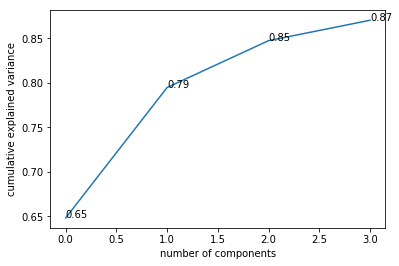

In [142]:
#The visualization for total explaained variance ratio for 4 components.
a = range(len(X_train[1]))
b = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
for i,j in zip(a,b):
    ax.annotate(str(round(j,2)),xy=(i,j))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## Building Models

### 6. Fit a baseline model (simple average of the column).

In [143]:
# The baseline predictions are the historical averages
baseline_preds = y['medianPopulation'].mean()

# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - y_test['medianPopulation'])

print('Mean Absolute Error(MAE) of Baseline model: ', round(np.mean(baseline_errors), 2))

Mean Absolute Error(MAE) of Baseline model:  119420.17


### 7.Fit a random forest model with hyperparameter tuning (your choice what to tune!).

In [144]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 1000, random_state = 123)
rf.fit(X_train, y_train['medianPopulation'])

# Use the forest's predict method on the test data
rf_predictions = rf.predict(X_test)
# Calculate the absolute errors
rf_errors = abs(rf_predictions - y_test['medianPopulation'])
# Print out the mean absolute error (mae)
print('MAE of Basic Random Forest:', round(np.mean(rf_errors), 2), 'degrees.')

MAE of Basic Random Forest: 63198.38 degrees.


In [145]:
print("Feature Importances:",rf.feature_importances_)
print("Random Forest Scores", round(rf.score(X_test, y_test['medianPopulation']),2))

Feature Importances: [0.35973192 0.28044168 0.21510331 0.14472309]
Random Forest Scores 0.49


In [146]:
#Tunning the model based on the results from RandomizedSearchCV
rf1 = RandomForestRegressor(random_state = 123, 
                            bootstrap = True, max_depth = 20,
                            max_features = 'sqrt', min_samples_leaf = 1,
                            min_samples_split = 2, n_estimators = 1000)
rf1.fit(X_train, y_train['medianPopulation'])

# Use the forest's predict method on the test data
predictions1 = rf1.predict(X_test)
# Calculate the absolute errors
errors1 = abs(predictions1 - y_test['medianPopulation'])
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors1), 2), 'degrees.')

Mean Absolute Error: 61976.37 degrees.


In [147]:
#By Far the Best one with the lowest MAE.
rf2 = RandomForestRegressor(random_state = 123, 
                            bootstrap = True, max_depth = 110,
                            max_features ='sqrt', min_samples_leaf =1,
                            min_samples_split = 2, n_estimators = 1000)
rf2.fit(X_train, y_train['medianPopulation'])

# Use the forest's predict method on the test data
predictions2 = rf2.predict(X_test)
# Calculate the absolute errors
errors2 = predictions2 - y_test['medianPopulation']
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(np.abs(errors2)), 2), 'degrees.')

Mean Absolute Error: 61750.52 degrees.


#### Random Hyperparameter Grid << Tried to find the best combination of parameters

In [148]:
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(random_state = 123)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [149]:
'''
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv=3,verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
'''

'\n# Use the random grid to search for best hyperparameters\n# First create the base model to tune\nrf = RandomForestRegressor()\n# Random search of parameters, using 3 fold cross validation, \n# search across 100 different combinations, and use all available cores\nrf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv=3,verbose=2, random_state=42, n_jobs = -1)\n# Fit the random search model\nrf_random.fit(X_train, y_train)\n'

In [150]:
'''
pprint(rf_random.best_params_)

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}
 '''

"\npprint(rf_random.best_params_)\n\n{'bootstrap': True,\n 'max_depth': 20,\n 'max_features': 'sqrt',\n 'min_samples_leaf': 1,\n 'min_samples_split': 2,\n 'n_estimators': 1000}\n "

In [151]:
'''
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
  
base_model = RandomForestRegressor(n_estimators = 10, random_state = 123)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

'''

"\ndef evaluate(model, test_features, test_labels):\n    predictions = model.predict(test_features)\n    errors = abs(predictions - test_labels)\n    mape = 100 * np.mean(errors / test_labels)\n    accuracy = 100 - mape\n    print('Model Performance')\n    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))\n    print('Accuracy = {:0.2f}%.'.format(accuracy))\n    \n    return accuracy\n  \nbase_model = RandomForestRegressor(n_estimators = 10, random_state = 123)\nbase_model.fit(X_train, y_train)\nbase_accuracy = evaluate(base_model, X_test, y_test)\n\nbest_random = rf_random.best_estimator_\nrandom_accuracy = evaluate(best_random, X_test, y_test)\n\nprint('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))\n\n"

### 8. Fit a neural network - your choice how to optimize the size of the network. Use dropout or L1/L2 regularization in your model.

Train on 2010 samples, validate on 503 samples
Epoch 1/30
2010/2010 [==============================] - 11s 5ms/step - loss: 95958.6909 - mean_absolute_error: 95958.6909 - val_loss: 73768.8924 - val_mean_absolute_error: 73768.8924
Epoch 2/30
2010/2010 [==============================] - 10s 5ms/step - loss: 65826.2560 - mean_absolute_error: 65826.2560 - val_loss: 54903.3513 - val_mean_absolute_error: 54903.3513
Epoch 3/30
2010/2010 [==============================] - 10s 5ms/step - loss: 62079.7248 - mean_absolute_error: 62079.7248 - val_loss: 54254.9909 - val_mean_absolute_error: 54254.9909
Epoch 4/30
2010/2010 [==============================] - 10s 5ms/step - loss: 61223.1684 - mean_absolute_error: 61223.1684 - val_loss: 53993.9697 - val_mean_absolute_error: 53993.9697
Epoch 5/30
2010/2010 [==============================] - 10s 5ms/step - loss: 61248.8508 - mean_absolute_error: 61248.8508 - val_loss: 55737.4045 - val_mean_absolute_error: 55737.4045
Epoch 6/30
2010/2010 [================

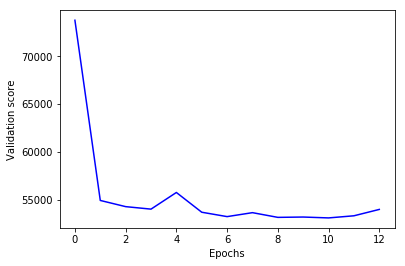

In [152]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras import Sequential
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error

n_cols = X_train.shape[1]

earlystopping = EarlyStopping(patience=2)

nn = Sequential()

nn.add(Dense(2000,activation='relu',input_shape = (n_cols,)))
nn.add(Dropout(0.2))
nn.add(Dense(2000,activation='relu'))
nn.add(Dropout(0.2))
nn.add(Dense(2000,activation='relu'))
##Output layer
nn.add(Dense(1,activation = 'linear'))
##Compile the network
nn.compile(optimizer='adam',loss='mean_absolute_error',metrics=['mean_absolute_error'])
##Fit the model
nn_training = nn.fit(X_train,y_train['medianPopulation'] ,epochs=30,validation_split=0.2,callbacks=[earlystopping])
##Create the plot
plt.plot(nn_training.history['val_loss'],'b')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()


In [153]:
ann_val = abs(nn.predict(X_test)-y_test['medianPopulation'].values)
mae_ann_train = mean_absolute_error(y_train['medianPopulation'],nn.predict(X_train))
mae_ann_val = mean_absolute_error(y_test['medianPopulation'],nn.predict(X_test))

print(mae_ann_train)
print(mae_ann_val)

57952.725136871886
58945.96903217844


### 9. Perform 10-fold cross-validation on the 80% training data (I recommend you code it by hand manually), save the score for each record when it is in the validation fold. Then, apply the model to the test data (20% heldout) and save the score.

In [154]:
from sklearn.metrics import mean_absolute_error

k=10
num_val_samples = len(X_train) // k


rf_ae_train = []
rf_ae_val = []
rf_ae_test = []
nn_ae_train = []
nn_ae_val = []
nn_ae_test = []
rf_pred_train= []
rf_pred_val= []
rf_pred_test= []
nn_pred_train= []
nn_pred_val= []
nn_pred_test= []
act_train = []
act_val= []
act_test =[]

for i in range(k):
  print('processing fold #', i)
  val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples] 
  val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
  
  partial_train_data = np.concatenate( [X_train[:i * num_val_samples], X_train[(i + 1) * num_val_samples:]], axis=0)
  partial_train_targets = np.concatenate( [y_train[:i * num_val_samples], y_train[(i + 1) * num_val_samples:]], axis=0)

  rf2.fit(partial_train_data, partial_train_targets[:,0])
  nn.fit(partial_train_data, partial_train_targets[:,0], verbose=0)

  rf_predtrain = rf2.predict(partial_train_data)
  rf_errors_train = mean_absolute_error(rf_predtrain, partial_train_targets[:,0])
  nn_predtrain = nn.predict(partial_train_data)
  nn_errors_train = mean_absolute_error(nn_predtrain, partial_train_targets[:,0])

  rf_predval = rf2.predict(val_data)
  rf_errors_val = mean_absolute_error(rf_predval, val_targets['medianPopulation'].values)
  nn_predval = nn.predict(val_data)
  nn_errors_val = mean_absolute_error(nn_predval, val_targets['medianPopulation'].values)

  rf_predtest = rf2.predict(X_test)
  rf_errors_test = mean_absolute_error(rf_predtest, y_test['medianPopulation'].values)
  nn_predtest = nn.predict(X_test)
  nn_errors_test = mean_absolute_error(nn_predtest, y_test['medianPopulation'].values)
  
  
  rf_ae_train.append(rf_errors_train)
  rf_ae_val.append(rf_errors_val)
  rf_ae_test.append(rf_errors_test)
  
  nn_ae_train.append(nn_errors_train)
  nn_ae_val.append(nn_errors_val)
  nn_ae_test.append(nn_errors_test)
  
  rf_pred_train.append(rf_predtrain)
  rf_pred_val.append(rf_predval)
  rf_pred_test.append(rf_predtest)
  
  nn_pred_train.append(nn_predtrain)
  nn_pred_val.append(nn_predval)
  nn_pred_test.append(nn_predtest)

  act_train.append(partial_train_targets)
  act_val.append(val_targets)
  act_test.append(y_test)


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9


### Output1 - A table that has the MAE (sd) of each model (training, validation and test results)

In [155]:
error_array = []
MAE_train_rf = round(np.mean(np.abs(rf_ae_train)),2)
MAE_train_nn = round(np.mean(np.abs(nn_ae_train)),2)
SD_train_rf = round(np.std(np.abs(rf_ae_train)),2)
SD_train_nn = round(np.std(np.abs(nn_ae_train)),2)

MAE_val_rf = round(np.mean(np.abs(rf_ae_val)),2)
MAE_val_nn = round(np.mean(np.abs(nn_ae_val)),2)
SD_val_rf = round(np.std(np.abs(rf_ae_val)),2)
SD_val_nn = round(np.std(np.abs(nn_ae_val)),2)

MAE_test_rf = round(np.mean(np.abs(rf_ae_test)),2)
MAE_test_nn = round(np.mean(np.abs(nn_ae_test)),2)
SD_test_rf = round(np.std(np.abs(rf_ae_test)),2)
SD_test_nn = round(np.std(np.abs(nn_ae_test)),2)
error_array.append([MAE_train_rf, SD_train_rf, MAE_val_rf, SD_val_rf, MAE_test_rf, SD_test_rf])
error_array.append([MAE_train_nn, SD_train_nn, MAE_val_nn, SD_val_nn, MAE_test_nn, SD_test_nn])

error_df = pd.DataFrame(error_array, columns = ['Train MAE', '(sd)', 'Validation MAE', '(sd)', 'Test MAE', '(sd)'])
error_df.rename(index={0:'Random Forest', 1:'Neural Network'}, inplace=True)
display(error_df)

,Train MAE,(sd),Validation MAE,(sd),Test MAE,(sd)
Random Forest,22855.17,590.56,63327.88,13241.98,62493.82,1534.79
Neural Network,56751.01,1709.06,56970.12,13617.32,57690.72,478.83


 ### Output2 - Scatterplot
 Make a scatterplot of actual vs. predicted values (training vs. validation results)

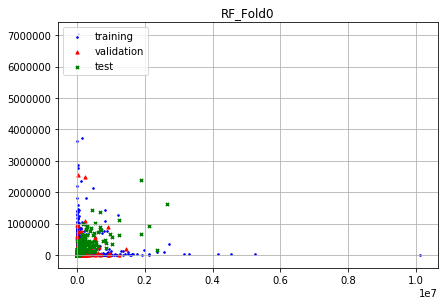

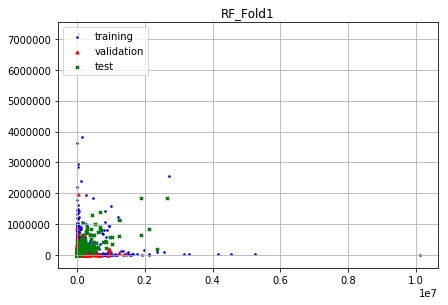

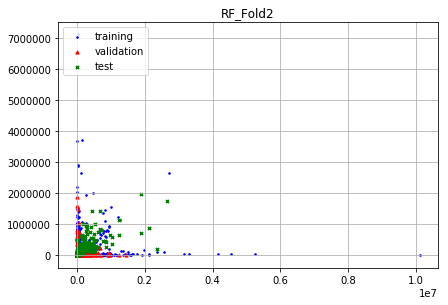

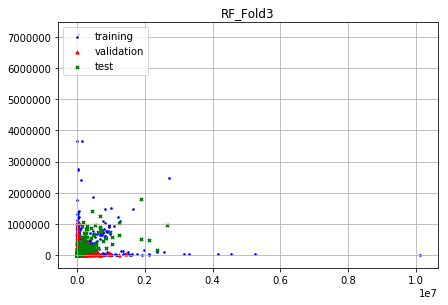

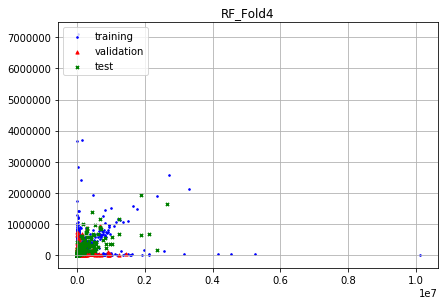

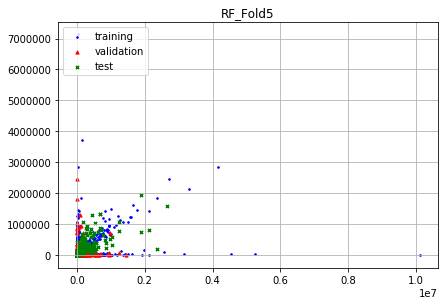

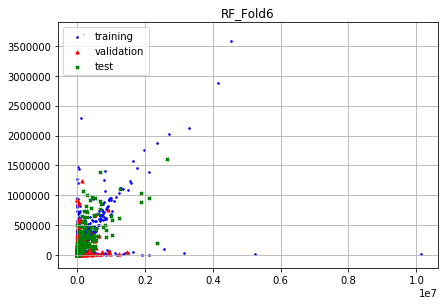

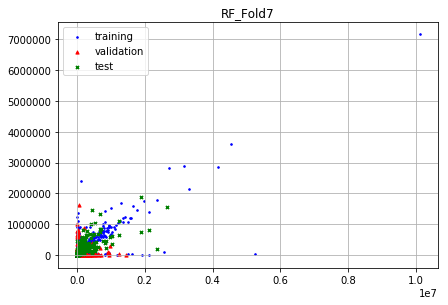

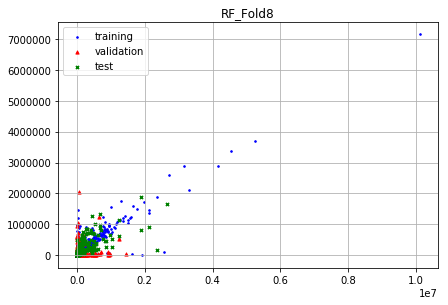

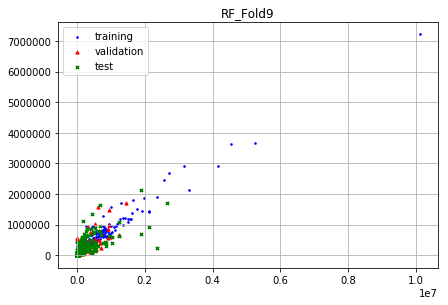

In [156]:
#Random Forest Scatterplot
for i in range(10):
  fig, ax = plt.subplots()
  ax.grid(True)
  fig.tight_layout()
  ax.scatter(partial_train_targets[:,0],rf_pred_train[i], s=10, c='b', marker=".", label='training')
  ax.scatter(val_targets['medianPopulation'],rf_pred_val[i], s=10, c='r', marker="^", label='validation')
  ax.scatter(y_test['medianPopulation'],rf_pred_test[i], s=10, c='g', marker="x", label='test')
  
  ax.set_title('RF_Fold'+str(i))
  plt.legend(loc='upper left');
plt.show()

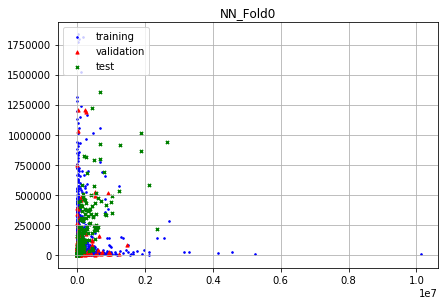

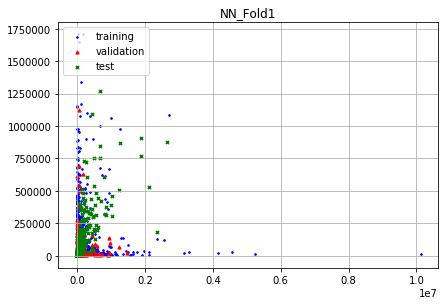

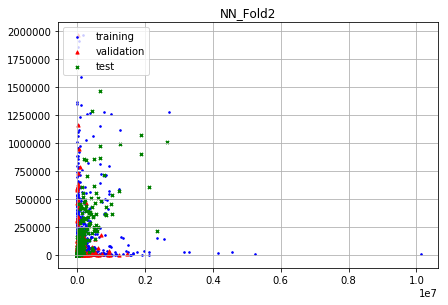

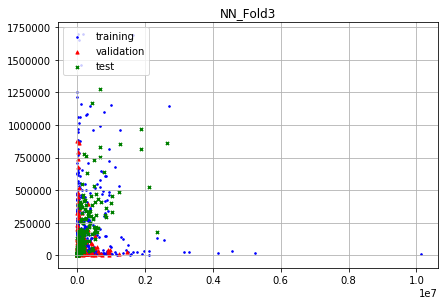

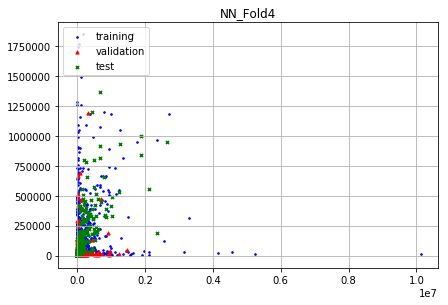

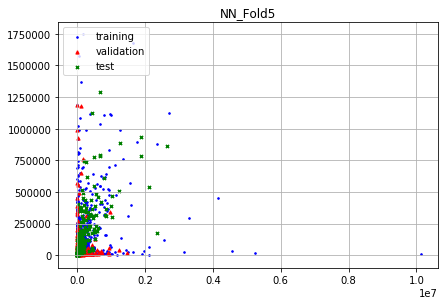

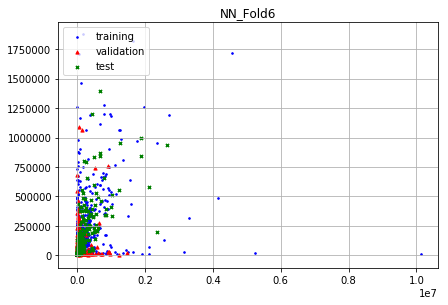

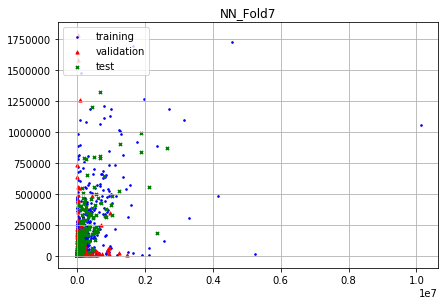

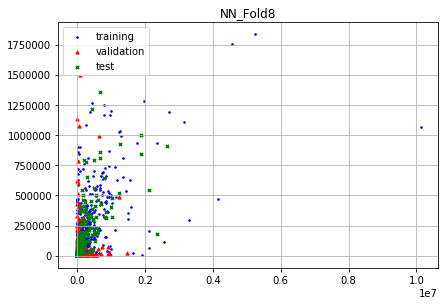

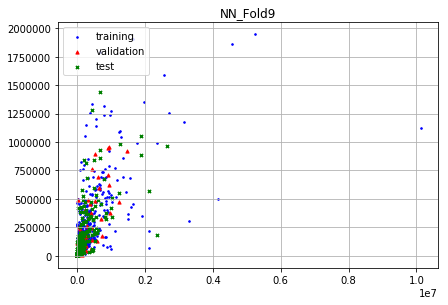

In [157]:
#Neural Network Scatterplot
for i in range(10):
  fig, ax = plt.subplots()
  ax.grid(True)
  fig.tight_layout()
  ax.scatter(partial_train_targets[:,0],nn_pred_train[i], s=10, c='b', marker=".", label='training')
  ax.scatter(val_targets['medianPopulation'],nn_pred_val[i], s=10, c='r', marker="^", label='validation')
  ax.scatter(y_test['medianPopulation'],nn_pred_test[i], s=10, c='g', marker="x", label='test')
  
  ax.set_title('NN_Fold'+str(i))
  plt.legend(loc='upper left');
plt.show()

### Output3 - Boxplot
show a 10-panel boxplot of error (pred - actual) per group. 

In [0]:
dfbp = pd.concat([errors2, y_test['group']], axis=1, )
dfbp.columns=['rf_err','gp']
dfbp['rf_err'] = dfbp['rf_err'].astype(float)

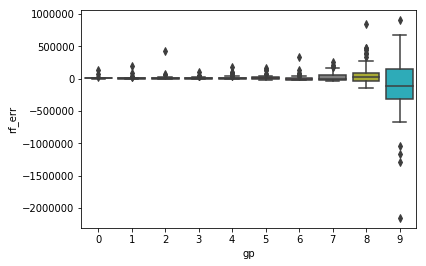

In [159]:
import seaborn as sns
ax = sns.boxplot(x='gp', y='rf_err', data=dfbp)

In [160]:
df_sorted_pop.groupby('group')['medianPopulation'].agg(['sum','count','std'])

,sum,count,std
group,,,
0,888035,315,1307.9532
1,2215054,314,1116.1196
2,3496567,315,1325.3044
3,4997947,313,1456.6583
4,6940676,314,2007.0689
5,9677432,314,3239.9928
6,13758691,314,4663.4417
7,21788656,314,11180.0299
8,43404218,314,32181.9731


### Output4 - A list of the 50 worst predicted counties in the US from the test data

In [161]:
def AE_func(y_true,y_pred):
  y_true,y_pred = np.array(y_true),np.array(y_pred)
  return np.abs(y_pred - y_true)

pred_rf = rf2.predict(X_test)
pred_ann = nn.predict(X_test)

avg_pred_pop = pred_rf
df2 = pd.DataFrame(columns = ['medianPopulation','index','avg_pred_pop'])              
df2['medianPopulation'] = y_test['medianPopulation']
df2['index']=y_test['index']
df2['avg_pred_pop'] = avg_pred_pop
avg_ae = AE_func(df2['medianPopulation'],df2['avg_pred_pop'])

df2['avg_ae'] = avg_ae
df3 = pd.merge(df2,df,on = ["index"],how = "inner")
df3.head()
  

,medianPopulation_x,index,avg_pred_pop,avg_ae,STATEFP,COUNTYFP,GEOID,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,DW10,DW11,DW12,DW13,DW14,DW15,DW16,DW17,DW18,DW19,DW20,DW21,DW22,DW23,DW24,DW25,DW26,DW27,...,DW435,DW436,DW437,DW438,DW439,DW440,DW441,DW442,DW443,DW444,DW445,DW446,DW447,DW448,DW449,DW450,DW451,DW452,DW453,DW454,DW455,DW456,DW457,DW458,DW459,DW460,DW461,DW462,DW463,DW464,DW465,DW466,DW467,DW468,SUMLEV,REGION,DIVISION,STNAME,CTYNAME,medianPopulation_y
0,21523,2629,16405.028,5118,5,149,5149,69908,0500000US05149,Yell,6,2409046726,48482972,-0.08,0.01,0.02,0.03,0.05,0.08,0.13,0.26,0.57,0.86,1.271,2.9,35.52,-0.13,-0.06,-0.05,-0.04,-0.03,0,0.04,0.16,0.44,0.73,1.22,3.05,30.45,-0.1,...,0.34,0.39,0.49,0.78,1.07,1.56,3.591,81.35,0.23,0.31,0.33,0.34,0.36,0.39,0.44,0.55,0.85,1.17,1.74,3.85,85.63,0.2,0.24,0.26,0.27,0.28,0.31,0.37,0.49,0.77,1.07,1.57,3.711,61.19,50,3,7,Arkansas,Yell,21523
1,16414,746,25445.185,9031,20,5,20005,484972,0500000US20005,Atchison,6,1116736559,6851102,-0.01,0.03,0.04,0.06,0.07,0.1,0.13,0.2,0.36,0.7,1.62,5.536,44.26,-0.03,0.01,0.03,0.0455,0.06,0.1,0.15,0.22,0.37,0.64,1.85,7.36,46.77,0,...,0.41,0.46,0.52,0.68,1.05,2.965,11.53,67.03,0.34,0.39,0.41,0.42,0.43,0.46,0.5,0.57,0.73,1.08,2.828,10.84,65.01,0.23,0.28,0.29,0.3,0.31,0.34,0.39,0.46,0.6,0.95,2.58,9.486,61.8,50,2,4,Kansas,Atchison,16414
2,15539,1069,49519.432,3.398e+04,26,53,26053,1622969,0500000US26053,Gogebic,6,2854517985,970153168,-0.53,-0.31,-0.23,-0.16,-0.07,0,0.06,0.12,0.32,0.43,0.68,1.44,42.64,-0.19,-0.04,-0.01,0,0,0,0,0,0,0,0,0,0,-0.19,...,0.35,0.4,0.46,0.78,1.597,3.67,11.04,177.5,0.27,0.33,0.35,0.36,0.37,0.4,0.44,0.49,0.81,1.847,3.88,10.22,179.9,0.11,0.17,0.18,0.19,0.21,0.23,0.26,0.3,0.37,0.54,0.88,2.74,54.83,50,2,3,Michigan,Gogebic,15539
3,2504,699,2582.020,78.02,20,153,20153,485040,0500000US20153,Rawlins,6,2769775729,415527,-0.12,-0.06,-0.05,-0.04,-0.02,0,0.02,0.05,0.08,0.11,0.15,0.28,11.5,-0.26,-0.08,-0.06,-0.04,-0.03,-0.01,0.02,0.04,0.07,0.09,0.13,0.27,12.71,-0.06,...,0.33,0.36,0.39,0.42,0.44,0.48,0.63,23.42,0.27,0.33,0.34,0.35,0.36,0.38,0.4,0.43,0.46,0.48,0.54,0.71,19.63,0.14,0.21,0.22,0.23,0.25,0.27,0.3,0.32,0.35,0.38,0.41,0.55,18.81,50,2,4,Kansas,Rawlins,2504
4,39687,2241,42056.084,2369,47,13,47013,1639728,0500000US47013,Campbell,6,1243615773,46494677,-0.02,0.07,0.1,0.11,0.14,0.2,0.33,0.79,1.98,3.84,7.041,15.12,39.9,-0.08,-0.01,0.01,0.02,0.04,0.08,0.18,0.53,1.43,2.79,4.891,10.44,36.55,-0.05,...,0.5,0.6,1.01,2.31,4.501,8.108,18.17,64.12,0.37,0.43,0.45,0.46,0.49,0.53,0.62,1.03,2.31,4.18,7.465,16.98,59.53,0.21,0.27,0.29,0.31,0.33,0.37,0.48,0.86,2.04,3.84,6.947,14.84,64.65,50,3,6,Tennessee,Campbell,39687


In [163]:
import heapq
c=heapq.nlargest(50, df3.loc[:,'avg_ae'])
d = df3.loc[:,'avg_ae']
e = d.tolist()
f = pd.DataFrame()
for q in c:
    p=e.index(q)
    f['avg_ae'] = q
    f['STNAME'] = df3.loc[p,'STNAME']
    f['CTYNAME'] = df3.loc[p,'CTYNAME']
    
f['avg_ae'] = c
f['STNAME'] = df3.loc[:,'STNAME']
f['CTYNAME'] = df3.loc[:,'CTYNAME']
f

,avg_ae,STNAME,CTYNAME
0,2.1181e+06,Arkansas,Yell
1,1.2002e+06,Kansas,Atchison
2,1.1799e+06,Michigan,Gogebic
3,9.4875e+05,Kansas,Rawlins
4,9.4870e+05,Tennessee,Campbell
5,9.4611e+05,Tennessee,Warren
6,8.8589e+05,Indiana,Jasper
7,6.4400e+05,Georgia,Webster
8,6.1888e+05,Illinois,Cass
9,5.5533e+05,New York,Orleans
